Basic Environment Installment

In [2]:
pip install rasterio numpy pandas tqdm pvlib rtree

   ---------------------------------------- 0.0/389.4 kB ? eta -:--:--
   ------------------------------------ -- 368.6/389.4 kB 11.6 MB/s eta 0:00:01
   ---------------------------------------- 389.4/389.4 kB 8.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Hillshade

2024-01-01 00:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-01 01:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-01 02:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-01 03:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-01 04:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-01 05:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-01 06:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-01 07:00:00+09:00: apparent_elevation < 0, Hillshade 미생성


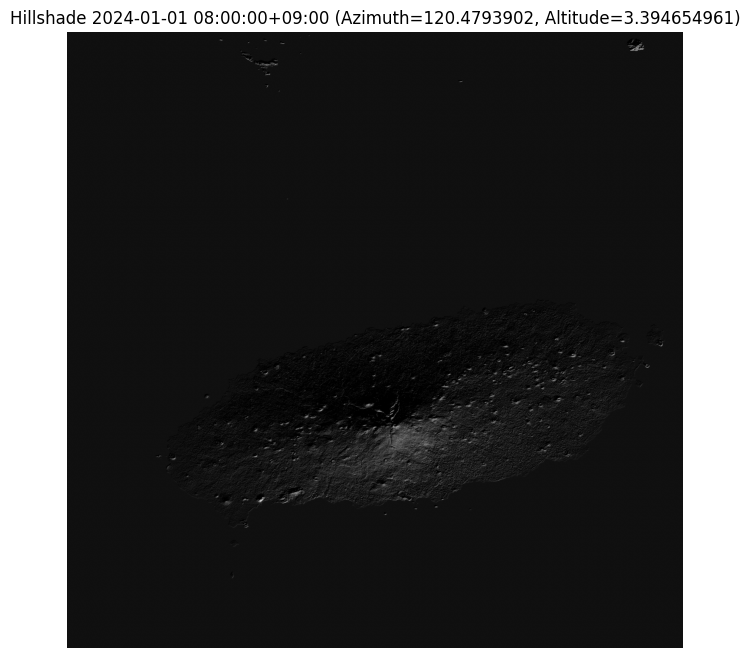

2024-01-01 18:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-01 19:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-01 20:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-01 21:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-01 22:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-01 23:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-02 00:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-02 01:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-02 02:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-02 03:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-02 04:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-02 05:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-02 06:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-02 07:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-02 18:00:00+09:00: apparent_elevation < 0, Hillshade 미생성
2024-01-02 19:00:00+09:00

In [4]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
from rasterio.plot import show
import matplotlib.pyplot as plt
import os
import re

# DEM 및 Solar position 파일 경로
dem_path = r"C:\Users\user\Desktop\Junkyo\2025\Jeju_Sectorcoupling\GIS\DEM\ASTGTMV003_N33E126_dem.tif"
solar_path = r"C:\Users\user\Desktop\Junkyo\2025\Jeju_Sectorcoupling\GIS\DEM\solar_position_1hour.csv"
output_dir = r"D:\Junkyo\2025\Jeju_Sectorcoupling\Hillshade"

# 결과 저장 폴더가 없으면 생성
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# DEM 파일 읽기
with rasterio.open(dem_path) as dem_src:
    dem = dem_src.read(1)
    dem_transform = dem_src.transform
    dem_crs = dem_src.crs
    dem_profile = dem_src.profile

# Solar position 데이터 읽기
solar_df = pd.read_csv(solar_path)

# Hillshade 계산 함수
def hillshade(array, azimuth, altitude):
    x, y = np.gradient(array, 30, 30)  # 30m 해상도
    slope = np.pi/2 - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuth_rad = np.deg2rad(azimuth)
    altitude_rad = np.deg2rad(altitude)
    shaded = np.sin(altitude_rad) * np.sin(slope) + \
             np.cos(altitude_rad) * np.cos(slope) * np.cos(azimuth_rad - aspect)
    shaded = np.clip(shaded, 0, 1)
    return (shaded * 255).astype(np.uint8)

def safe_filename(s):
    # 파일명에 사용할 수 없는 문자 모두 _로 변환
    return re.sub(r'[\\/:*?"<>|+ ]', '_', str(s))

# 반복문: apparent_elevation > 0인 경우만 hillshade 생성 및 저장
visualized = False
for idx, row in solar_df.iterrows():
    azimuth = row['azimuth']
    altitude = row['apparent_elevation']
    timestamp = row['timestamp']
    if altitude > 0:
        hillshade_img = hillshade(dem, azimuth, altitude)
        # 첫 번째 생성 이미지만 시각화
        if not visualized:
            plt.figure(figsize=(8,8))
            plt.title(f"Hillshade {timestamp} (Azimuth={azimuth}, Altitude={altitude})")
            plt.imshow(hillshade_img, cmap='gray')
            plt.axis('off')
            plt.show()
            visualized = True
        # 저장
        output_hillshade = os.path.join(output_dir, f"hillshade_{safe_filename(timestamp)}.tif")
        with rasterio.open(
            output_hillshade,
            'w',
            driver='GTiff',
            height=hillshade_img.shape[0],
            width=hillshade_img.shape[1],
            count=1,
            dtype=hillshade_img.dtype,
            crs=dem_crs,
            transform=dem_transform
            ) as dst:
            dst.write(hillshade_img, 1)
    else:
        print(f"{timestamp}: apparent_elevation < 0, Hillshade 미생성")

Mask Non generation area

In [6]:
import os
import rasterio
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from tqdm import tqdm

# 입력 경로
raster_dir = r"D:\Junkyo\2025\Jeju_Sectorcoupling\Hillshade"
mask_shp = r"C:\Users\user\Desktop\Junkyo\2025\Jeju_Sectorcoupling\GIS\Jeju_Mask.shp"
output_dir = r"D:\Junkyo\2025\Jeju_Sectorcoupling\Mask"

# 결과 저장 폴더가 없으면 생성
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 마스크 폴리곤 불러오기 (WGS84)
mask_gdf = gpd.read_file(mask_shp)
mask_gdf = mask_gdf.to_crs(epsg=4326)  # WGS84 EPSG:4326
mask_polygons = mask_gdf.geometry

# 래스터 파일 목록
raster_files = [f for f in os.listdir(raster_dir) if f.lower().endswith('.tif')]

for fname in tqdm(raster_files, desc="Hillshade Masking"):
    raster_path = os.path.join(raster_dir, fname)
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        profile = src.profile.copy()
        transform = src.transform
        nodata = src.nodata if src.nodata is not None else 0
        height, width = data.shape

        # cell 중심 좌표 계산
        xs = np.arange(width) + 0.5
        ys = np.arange(height) + 0.5
        xs, ys = np.meshgrid(xs, ys)
        xs, ys = xs.flatten(), ys.flatten()
        lons, lats = rasterio.transform.xy(transform, ys, xs, offset="center")
        points = [Point(lon, lat) for lon, lat in zip(lons, lats)]

        # 폴리곤 내부 여부 판정 (cell 중심이 폴리곤 내부면 True)
        mask = np.zeros(data.shape, dtype=bool)
        for poly in mask_polygons:
            inside = np.array([poly.contains(pt) for pt in points])
            mask = mask | inside.reshape(data.shape)

        # 마스킹: 폴리곤 내부는 NoData, 외부는 기존 값 유지
        masked_data = data.copy()
        masked_data[mask] = nodata

        # 저장
        output_path = os.path.join(output_dir, fname)
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(masked_data, 1)

Hillshade Masking:   0%|          | 2/4432 [27:01<997:33:35, 810.66s/it]



Hillshade Masking:   0%|          | 2/4432 [27:01<997:33:35, 810.66s/it]



KeyboardInterrupt: 

In [1]:
#v2 accellerated
import os
import rasterio
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from tqdm import tqdm

raster_dir = r"D:\Junkyo\2025\Jeju_Sectorcoupling\Hillshade"
mask_shp = r"C:\Users\user\Desktop\Junkyo\2025\Jeju_Sectorcoupling\GIS\Jeju_Mask.shp"
output_dir = r"D:\Junkyo\2025\Jeju_Sectorcoupling\Mask"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

mask_gdf = gpd.read_file(mask_shp).to_crs(epsg=4326)

raster_files = [f for f in os.listdir(raster_dir) if f.lower().endswith('.tif')]

for fname in tqdm(raster_files, desc="Hillshade Masking"):
    raster_path = os.path.join(raster_dir, fname)
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        profile = src.profile.copy()
        transform = src.transform
        nodata = src.nodata if src.nodata is not None else 0
        height, width = data.shape

        # cell 중심 좌표를 벡터화하여 GeoDataFrame 생성
        rows, cols = np.indices((height, width))
        xs, ys = rasterio.transform.xy(transform, rows, cols, offset="center")
        flat_points = [Point(x, y) for x, y in zip(np.ravel(xs), np.ravel(ys))]
        points_gdf = gpd.GeoDataFrame(geometry=flat_points, crs=mask_gdf.crs)

        # 공간조인: cell 중심이 폴리곤 내부에 포함되는지
        joined = gpd.sjoin(points_gdf, mask_gdf, how="left", predicate="within")
        mask = ~joined.index_right.isna().values.reshape(data.shape)

        masked_data = data.copy()
        masked_data[mask] = nodata

        output_path = os.path.join(output_dir, fname)
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(masked_data, 1)

Hillshade Masking:   1%|          | 53/4432 [1:00:10<82:51:27, 68.12s/it]



Hillshade Masking:   1%|          | 53/4432 [1:00:10<82:51:27, 68.12s/it]



KeyboardInterrupt: 

In [ ]:
#v3 rtree 병렬
import os
import rasterio
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

raster_dir = r"D:\Junkyo\2025\Jeju_Sectorcoupling\Hillshade"
mask_shp = r"C:\Users\user\Desktop\Junkyo\2025\Jeju_Sectorcoupling\GIS\Jeju_Mask.shp"
output_dir = r"D:\Junkyo\2025\Jeju_Sectorcoupling\Mask"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

mask_gdf = gpd.read_file(mask_shp).to_crs(epsg=4326)

raster_files = [f for f in os.listdir(raster_dir) if f.lower().endswith('.tif')]

def mask_one_raster(fname):
    raster_path = os.path.join(raster_dir, fname)
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        profile = src.profile.copy()
        transform = src.transform
        nodata = src.nodata if src.nodata is not None else 0
        height, width = data.shape

        rows, cols = np.indices((height, width))
        xs, ys = rasterio.transform.xy(transform, rows, cols, offset="center")
        flat_points = [Point(x, y) for x, y in zip(np.ravel(xs), np.ravel(ys))]
        points_gdf = gpd.GeoDataFrame(geometry=flat_points, crs=mask_gdf.crs)

        joined = gpd.sjoin(points_gdf, mask_gdf, how="left", predicate="within")
        mask = ~joined.index_right.isna().values.reshape(data.shape)

        masked_data = data.copy()
        masked_data[mask] = nodata

        output_path = os.path.join(output_dir, fname)
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(masked_data, 1)
    return fname

if __name__ == "__main__":
    with Pool(cpu_count()) as pool:
        list(tqdm(pool.imap(mask_one_raster, raster_files), total=len(raster_files), desc="Hillshade Masking (Parallel)"))

Hillshade Masking (Parallel):   0%|          | 0/4432 [00:00<?, ?it/s]

Count Non-Zero Cell in polygon

In [1]:
#masking valid cells csv v2
import os
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd
import pandas as pd
from tqdm import tqdm

# 경로 설정
shp_path      = r"C:\Users\user\Desktop\Junkyo\2025\Jeju_Sectorcoupling\GIS\Jeju_Polygon.shp"
raster_folder = r"D:\Junkyo\2025\Jeju_Sectorcoupling\Mask_v5"
output_csv    = r"C:\Users\user\Desktop\Junkyo\2025\Jeju_Sectorcoupling\ValidCell\PowerArea_v5.csv"

# Shapefile 불러오기 및 CRS 확인
gdf = gpd.read_file(shp_path)
if gdf.crs is None or gdf.crs.to_epsg() != 2097:
    gdf = gdf.set_crs(epsg=2097, allow_override=True)

# 1행: EMD_CD 필드값 출력
print('EMD_CD 목록:', gdf['EMD_CD'].astype(str).tolist())

# 2행: 각 EMD_CD에 해당하는 NEAR_FID 필드값 출력
for emd_cd in gdf['EMD_CD'].astype(str).tolist():
    near_fid_values = gdf[gdf['EMD_CD'].astype(str) == emd_cd]['NEAR_FID'].tolist()
    print(f'EMD_CD: {emd_cd}, NEAR_FID: {near_fid_values}')

# EMD_CD 목록 추출
emd_codes = gdf["EMD_CD"].astype(str).tolist()

# 결과 저장 리스트
stats_list = []
raster_files = sorted([f for f in os.listdir(raster_folder) if f.lower().endswith('.tif')])

for fname in tqdm(raster_files, desc="래스터 처리중"):
    raster_path = os.path.join(raster_folder, fname)

    with rasterio.open(raster_path) as src:
        # 좌표계 변환
        gdf_proj = gdf.to_crs(src.crs)

        # 파일 결과 저장용 딕셔너리 (파일명 + 각 지역 유효 셀 수)
        result = {"RasterFile": fname}

        for idx, row in gdf_proj.iterrows():
            emd_codes = str(row["EMD_CD"])
            geom = [mapping(row.geometry)]

            try:
                out_img, _ = mask(
                    src,
                    geom,
                    all_touched=False,
                    crop=False,
                    filled=False
                )
                masked = out_img[0].astype("float32")
                masked[masked.mask] = np.nan

                non_zero_count = np.count_nonzero((~np.isnan(masked)) & (masked != 0))
                result[emd_codes] = non_zero_count

            except Exception as e:
                # 예외 발생 시 해당 구역은 0으로 간주
                result[emd_codes] = 0
                print(f"[경고] {fname}의 {emd_codes} 영역 처리 중 오류 발생: {e}")

        stats_list.append(result)

# 결과 DataFrame 생성 및 저장
stats_df = pd.DataFrame(stats_list)
stats_df.to_csv(output_csv, index=False, encoding="utf-8")

print("CSV 파일이 생성되었습니다:", output_csv)

EMD_CD 목록: ['50110131', '50110126', '50110123', '50110128', '50110125', '50110140', '50110120', '50110102', '50110310', '50110129', '50110127', '50110117', '50110114', '50110112', '50110136', '50110122', '50110113', '50110118', '50110256', '50110135', '50110111', '50110124', '50110132', '50110139', '50110138', '50110259', '50110110', '50110137', '50110116', '50110109', '50110121', '50110101', '50110133', '50110108', '50110106', '50110103', '50110107', '50110130', '50110104', '50110119', '50110330', '50110105', '50110115', '50110253', '50110134', '50110320', '50110250', '50130111', '50130310', '50130250', '50130101', '50130120', '50130117', '50130115', '50130119', '50130107', '50130121', '50130110', '50130109', '50130113', '50130104', '50130118', '50130122', '50130105', '50130116', '50130106', '50130320', '50130114', '50130112', '50130102', '50130103', '50130108', '50130259', '50130253']
EMD_CD: 50110131, NEAR_FID: [1]
EMD_CD: 50110126, NEAR_FID: [1]
EMD_CD: 50110123, NEAR_FID: [1]
EMD_

래스터 처리중:   0%|          | 0/4432 [00:00<?, ?it/s]c:\Users\user\miniconda3\Lib\site-packages\rasterio\mask.py:88: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '
c:\Users\user\miniconda3\Lib\site-packages\rasterio\mask.py:88: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '
래스터 처리중: 100%|██████████| 4432/4432 [12:01:01<00:00,  9.76s/it]  

EMD_CD 목록: ['50110131', '50110126', '50110123', '50110128', '50110125', '50110140', '50110120', '50110102', '50110310', '50110129', '50110127', '50110117', '50110114', '50110112', '50110136', '50110122', '50110113', '50110118', '50110256', '50110135', '50110111', '50110124', '50110132', '50110139', '50110138', '50110259', '50110110', '50110137', '50110116', '50110109', '50110121', '50110101', '50110133', '50110108', '50110106', '50110103', '50110107', '50110130', '50110104', '50110119', '50110330', '50110105', '50110115', '50110253', '50110134', '50110320', '50110250', '50130111', '50130310', '50130250', '50130101', '50130120', '50130117', '50130115', '50130119', '50130107', '50130121', '50130110', '50130109', '50130113', '50130104', '50130118', '50130122', '50130105', '50130116', '50130106', '50130320', '50130114', '50130112', '50130102', '50130103', '50130108', '50130259', '50130253']
EMD_CD: 50110131, NEAR_FID: [1]
EMD_CD: 50110126, NEAR_FID: [1]
EMD_CD: 50110123, NEAR_FID: [1]
EMD_

래스터 처리중:   0%|          | 0/4432 [00:00<?, ?it/s]c:\Users\user\miniconda3\Lib\site-packages\rasterio\mask.py:88: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '
c:\Users\user\miniconda3\Lib\site-packages\rasterio\mask.py:88: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '
래스터 처리중: 100%|██████████| 4432/4432 [12:01:01<00:00,  9.76s/it]  

CSV 파일이 생성되었습니다: C:\Users\user\Desktop\Junkyo\2025\Jeju_Sectorcoupling\ValidCell\PowerArea_v5.csv


In [ ]:
# 1행: EMD_CD 필드값 출력
print('EMD_CD 목록:', gdf['EMD_CD'].astype(str).tolist())

# 2행: 각 EMD_CD에 해당하는 NEAR_FID 필드값 출력
for emd_cd in gdf['EMD_CD'].astype(str).tolist():
    near_fid_values = gdf[gdf['EMD_CD'].astype(str) == emd_cd]['NEAR_FID'].tolist()
    print(f'EMD_CD: {emd_cd}, NEAR_FID: {near_fid_values}')

In [4]:
import os

# 경로를 각각 지정
test_paths = [
    r"D:\Junkyo\2025\Jeju_Sectorcoupling\SolarArea",  # shp_path
    r"D:\Junkyo\2025\WREC\Korea_hillshade",          # raster_folder
    r"C:\Users\user\Desktop\Junkyo\2025\Jeju_Sectorcoupling\ValidCell"  # output_csv 폴더
]

for path in test_paths:
    print(f"경로: {path}")
    # 폴더인지 파일인지 구분
    if os.path.isdir(path):
        # 폴더에 임시 파일 생성/삭제로 쓰기 권한 확인
        try:
            testfile = os.path.join(path, "permission_test.tmp")
            with open(testfile, "w") as f:
                f.write("test")
            os.remove(testfile)
            print("쓰기 권한: 있음")
        except Exception as e:
            print(f"쓰기 권한: 없음 ({e})")
        # 읽기 권한 확인
        try:
            files = os.listdir(path)
            print("읽기 권한: 있음")
        except Exception as e:
            print(f"읽기 권한: 없음 ({e})")
    else:
        # 파일에 대해 읽기/쓰기 권한 확인
        try:
            with open(path, "r") as f:
                f.read(1)
            print("읽기 권한: 있음")
        except Exception as e:
            print(f"읽기 권한: 없음 ({e})")
        try:
            with open(path, "a") as f:
                f.write("")
            print("쓰기 권한: 있음")
        except Exception as e:
            print(f"쓰기 권한: 없음 ({e})")
    print("-" * 40)

경로: D:\Junkyo\2025\Jeju_Sectorcoupling\SolarArea
쓰기 권한: 있음
읽기 권한: 있음
----------------------------------------
경로: D:\Junkyo\2025\WREC\Korea_hillshade
쓰기 권한: 있음
읽기 권한: 있음
----------------------------------------
경로: C:\Users\user\Desktop\Junkyo\2025\Jeju_Sectorcoupling\ValidCell
쓰기 권한: 있음
읽기 권한: 있음
----------------------------------------
